<a href="https://colab.research.google.com/github/deep1003/deep1003/blob/master/Week%2014.%20Patent%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# 구글 드라이브의 경로로 이동
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

# 현재 작업 디렉토리 확인
!pwd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [3]:
# 1. 필수 패키지 설치 명령어 (Colab 환경용)
!pip install tqdm pandas numpy matplotlib nltk gensim scikit-learn ksvd

# nltk 데이터를 다운로드하는 명령어 (추가적으로 필요할 수 있음)
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# 1. 필수 패키지 및 모듈 임포트
import os  # 파일 경로 및 작업 디렉토리 제어
import math  # 수학적 연산을 위한 모듈
import time  # 시간 측정 및 지연 처리
import pickle  # 데이터 직렬화 및 역직렬화를 위한 모듈
from tqdm import tqdm  # 진행 상태 표시를 위한 모듈
import pandas as pd  # 데이터 분석을 위한 라이브러리 (DataFrame 처리)
tqdm.pandas()  # pandas 진행 상태 바 추가
import numpy as np  # 수치 연산을 위한 라이브러리
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 라이브러리
import matplotlib.cm as cm  # 색상 맵 제어
from pprint import pprint  # 데이터 구조를 잘 보이게 출력하는 모듈
import re  # 정규 표현식을 위한 모듈
import nltk  # 자연어 처리 라이브러리
import gensim  # 토픽 모델링 및 임베딩 처리
from gensim.test.utils import datapath  # Gensim 데이터 경로 유틸리티
from gensim.models import Word2Vec  # Word2Vec 모델
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS  # 문구 학습 모델
from gensim.models.doc2vec import Doc2Vec, TaggedDocument  # Doc2Vec 모델
from gensim import corpora, models, similarities  # Gensim의 주요 모듈들
from sklearn.metrics.pairwise import cosine_similarity  # 코사인 유사도 계산
from gensim.models import KeyedVectors  # 사전 학습된 키 임베딩 로드
from random import seed, sample  # 랜덤 작업을 위한 모듈
import random  # 랜덤 작업을 위한 모듈
from ksvd import ApproximateKSVD  # KSVD(희소 코딩 알고리즘)
import sklearn  # 머신러닝 관련 라이브러리
from sklearn.decomposition import PCA  # 차원 축소를 위한 PCA
from sklearn.manifold import TSNE  # 차원 축소를 위한 t-SNE
from mpl_toolkits.mplot3d import Axes3D  # 3D 플롯 생성 도구
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder  # 인코딩 관련 라이브러리 (주석 처리됨)
# from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances  # 유사도 계산 모듈 (주석 처리됨)
import warnings  # 경고 무시 모듈
warnings.filterwarnings('ignore')  # 경고 메시지 무시 설정
from matplotlib.axes._axes import _log as matplotlib_axes_logger  # Matplotlib 경고 제어
matplotlib_axes_logger.setLevel('ERROR')  # Matplotlib 로그 레벨 설정 (오류만 출력)

import sys
sys.version

'3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]'

In [5]:
# 2. 데이터 로딩 함수, 각 데이터프레임의 셀 문자열을 리스트로 변환하는 함수
def string_to_ls(text):
    word_ls_strip = []  # 빈 리스트 생성
    word_ls = text.strip('][').split(', ')  # 입력 텍스트에서 '[]'를 제거하고, ', '로 분리하여 리스트로 변환

    # 각 단어에서 따옴표를 제거하고 리스트에 추가
    for w in word_ls:
        word_ls_strip.append(w.strip("'"))

    return word_ls_strip  # 리스트 반환


In [6]:
# # 3. 특허 데이터 다운로드 및 로드

# # 특허 데이터 다운로드 (특허 데이터가 없는 경우 아래에서 다운로드)
# # 먼저 https://patentsview.org/download/data-download-tables 에서 특허 초록 데이터를 다운로드하세요.

# # # 그 후, 특허 데이터셋을 메모리로 읽어들입니다.
# # patent_df = pd.read_csv("/content/drive/My Drive/data/g_assignee_disambiguated.tsv", low_memory=False, sep="\t")  # 특허 데이터를 TSV 파일로 읽어들임 (탭 구분)


# # 파일 경로 설정
# file_path = '/content/drive/My Drive/data/g_patent_abstract.tsv'

# # TSV 파일 로드
# patent_df = pd.read_csv(file_path, sep='\t', low_memory=False)

# # 데이터프레임의 크기(행, 열 수) 출력
# print(patent_df.shape)

# # 데이터프레임의 첫 5행 출력
# patent_df.head()



In [7]:
import pandas as pd

url = 'https://raw.githubusercontent.com/deep1003/deep1003/master/patent_finance.csv'

# Read the CSV file with separator ';'
patent_df = pd.read_csv(url, sep=';')

# Display the first few rows of the DataFrame
print(patent_df.head())


   appln_id  earliest_filing_year person_ctry_code cpc_class_symbol  \
0  48332311                  1992               US     G06N   3/049   
1  48332311                  1992               US     G06N   3/047   
2  53779347                  1990               US     G06N   3/048   
3  46469565                  1992               JP     Y10S 706/925   
4  52886028                  1990               JP     Y10S 706/902   

   nace2_code                                        appln_title  \
0        26.2  Method for operating a neural network with mis...   
1        26.2  Method for operating a neural network with mis...   
2        26.2   Operational speed improvement for neural network   
3        26.2  Economic phenomenon predicting and analyzing s...   
4        26.2                    Fuzzy backward reasoning device   

                                      appln_abstract  
0  A neural network system is provided that model...  
1  A neural network system is provided that model...  

In [8]:
# 컬럼명 변경
patent_df.rename(columns={'appln_abstract': 'abstract'}, inplace=True)

# 변경된 컬럼명 확인
patent_df


,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,A neural network system is provided that model...
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,A neural network system is provided that model...
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,Higher operational speed is obtained without s...
3,46469565,1992,JP,Y10S 706/925,26.2,Economic phenomenon predicting and analyzing s...,An economic phenomenon predicting and/or analy...
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,A sequential type Fuzzy backward reasoning dev...
...,...,...,...,...,...,...,...
70,46469565,1992,JP,Y10S 706/925,62.0,Economic phenomenon predicting and analyzing s...,An economic phenomenon predicting and/or analy...
71,46469565,1992,JP,G06N 3/049,62.0,Economic phenomenon predicting and analyzing s...,An economic phenomenon predicting and/or analy...
72,53445868,1991,US,Y10S 706/924,62.0,Health care payment adjudication and review sy...,A computerized expert system reviews and adjud...
73,51627208,1990,US,Y10S 706/925,62.0,Financial transaction network,A financial transaction network employs a shar...


In [9]:
# 4. 특허 초록 텍스트를 정리하는 함수 생성

def string_tokenize(text):
    workingIter = []  # 토큰을 저장할 리스트 초기화

    # 입력이 문자열인지 확인
    if isinstance(text, str):
        # NLTK를 사용해 텍스트를 토큰화 (단어 단위로 분리)
        tokenLst = nltk.word_tokenize(text)

        # 소문자로 변환, 알파벳만 남기기 (특수문자와 숫자는 제거)
        workingIter = [w.lower() for w in tokenLst if w.isalpha()]

    return workingIter  # 정리된 토큰 리스트 반환


In [10]:
# 5. 전처리된 토큰을 저장할 새로운 열 생성 및 데이터 저장

# "abstract" 열에 있는 텍스트를 토큰화한 결과를 "abstract_token" 열에 저장
patent_df["abstract_token"] = patent_df["abstract"].progress_apply(lambda x: string_tokenize(x))

# 필요한 열만 선택 (id, type, number, date, title, abstract_token)
# appln_id	earliest_filing_year	person_ctry_code	cpc_class_symbol	nace2_code	appln_title
patent_df = patent_df[['appln_id', 'earliest_filing_year', 'person_ctry_code', 'cpc_class_symbol', 'nace2_code','appln_title', 'abstract_token']]

# 전처리된 데이터를 CSV 파일로 저장 (index 없이 저장)
patent_df.to_csv("/content/drive/My Drive/data/patents_processed_tokens.csv", index=False)

# 데이터프레임의 크기 출력
print(patent_df.shape)

# 데이터프레임의 첫 5행 출력
patent_df.head()


100%|██████████| 75/75 [00:00<00:00, 850.91it/s]

(75, 7)


,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract_token
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,"[a, neural, network, system, is, provided, tha..."
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,"[a, neural, network, system, is, provided, tha..."
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,"[higher, operational, speed, is, obtained, wit..."
3,46469565,1992,JP,Y10S 706/925,26.2,Economic phenomenon predicting and analyzing s...,"[an, economic, phenomenon, predicting, analyzi..."
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni..."


In [11]:
#6 Load the processed data from above

patent_df = pd.read_csv("/content/drive/My Drive/data/patents_processed_tokens.csv", low_memory=False)
# Clean string the string of text column
patent_df["abstract_token"] = patent_df["abstract_token"].progress_apply(lambda x: string_to_ls(x))


100%|██████████| 75/75 [00:00<00:00, 10664.57it/s]


In [12]:
# 7. 학습 코퍼스 가져오기 (모든 특허 텍스트)

# "abstract_token" 열에서 전처리된 모든 특허 텍스트를 리스트로 변환
training_patent = list(patent_df["abstract_token"])

# 처음 5개와 마지막 5개 출력
print("처음 5개:", training_patent[:5])
print("마지막 5개:", training_patent[-5:])


처음 5개: [['a', 'neural', 'network', 'system', 'is', 'provided', 'that', 'models', 'the', 'system', 'in', 'a', 'system', 'model', 'with', 'the', 'output', 'thereof', 'providing', 'a', 'predicted', 'output', 'this', 'predicted', 'output', 'is', 'modified', 'or', 'controlled', 'by', 'an', 'output', 'control', 'input', 'data', 'is', 'processed', 'in', 'a', 'data', 'preprocess', 'step', 'to', 'reconcile', 'the', 'data', 'for', 'input', 'to', 'the', 'system', 'model', 'additionally', 'the', 'error', 'resulted', 'from', 'the', 'reconciliation', 'is', 'input', 'to', 'an', 'uncertainty', 'model', 'to', 'predict', 'the', 'uncertainty', 'in', 'the', 'predicted', 'output', 'this', 'is', 'input', 'to', 'a', 'decision', 'processor', 'which', 'is', 'utilized', 'to', 'control', 'the', 'output', 'control', 'the', 'output', 'control', 'is', 'controlled', 'to', 'either', 'vary', 'the', 'predicted', 'output', 'or', 'to', 'inhibit', 'the', 'predicted', 'output', 'whenever', 'the', 'output', 'of', 'the', 'un

In [13]:
# 전체 토큰의 갯수 계산
total_tokens = sum(len(doc) for doc in training_patent)

# 출력
print(f"전체 토큰의 갯수: {total_tokens}")


전체 토큰의 갯수: 13128


In [14]:
# 8. 모델 학습 (기본 설정 사용: min_count=5, threshold=10)

# Phrases 모델 학습 (기본 설정을 사용하여 토큰 간의 빈번한 쌍을 식별)
phrase_model = Phrases(training_patent, connector_words=ENGLISH_CONNECTOR_WORDS)


In [15]:
phrase_model

In [16]:
# 9. 각 특허 초록의 바이그램(bigram) 버전을 생성

# 각 "abstract_token" 리스트에서 바이그램 버전의 토큰 리스트를 생성
patent_df["abstract_token_bigram"] = patent_df["abstract_token"].progress_apply(lambda x: phrase_model[x])


100%|██████████| 75/75 [00:00<00:00, 4098.99it/s]


In [17]:
patent_df

,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract_token,abstract_token_bigram
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,"[a, neural, network, system, is, provided, tha...","[a, neural_network, system, is, provided, that..."
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,"[a, neural, network, system, is, provided, tha...","[a, neural_network, system, is, provided, that..."
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,"[higher, operational, speed, is, obtained, wit...","[higher, operational, speed, is, obtained, wit..."
3,46469565,1992,JP,Y10S 706/925,26.2,Economic phenomenon predicting and analyzing s...,"[an, economic, phenomenon, predicting, analyzi...","[an, economic_phenomenon, predicting, analyzin..."
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni...","[a, sequential, type, fuzzy, backward, reasoni..."
...,...,...,...,...,...,...,...,...
70,46469565,1992,JP,Y10S 706/925,62.0,Economic phenomenon predicting and analyzing s...,"[an, economic, phenomenon, predicting, analyzi...","[an, economic_phenomenon, predicting, analyzin..."
71,46469565,1992,JP,G06N 3/049,62.0,Economic phenomenon predicting and analyzing s...,"[an, economic, phenomenon, predicting, analyzi...","[an, economic_phenomenon, predicting, analyzin..."
72,53445868,1991,US,Y10S 706/924,62.0,Health care payment adjudication and review sy...,"[a, computerized, expert, system, reviews, and...","[a, computerized, expert, system, reviews, and..."
73,51627208,1990,US,Y10S 706/925,62.0,Financial transaction network,"[a, financial, transaction, network, employs, ...","[a, financial, transaction, network, employs, ..."


In [18]:
# 10. 필요한 열만 남기고 데이터프레임을 저장

# 필요한 열만 유지 (id, type, number, date, title, abstract_token_bigram)
patent_df = patent_df[['appln_id', 'earliest_filing_year', 'person_ctry_code', 'cpc_class_symbol', 'nace2_code','appln_title', 'abstract_token_bigram']]

# 전처리된 데이터를 CSV 파일로 저장 (index 없이 저장)
patent_df.to_csv("/content/drive/My Drive/data/patents_processed_bigrams.csv", index=False)


In [19]:
patent_df

,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract_token_bigram
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that..."
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that..."
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,"[higher, operational, speed, is, obtained, wit..."
3,46469565,1992,JP,Y10S 706/925,26.2,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin..."
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni..."
...,...,...,...,...,...,...,...
70,46469565,1992,JP,Y10S 706/925,62.0,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin..."
71,46469565,1992,JP,G06N 3/049,62.0,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin..."
72,53445868,1991,US,Y10S 706/924,62.0,Health care payment adjudication and review sy...,"[a, computerized, expert, system, reviews, and..."
73,51627208,1990,US,Y10S 706/925,62.0,Financial transaction network,"[a, financial, transaction, network, employs, ..."


In [20]:
# 11. 이전에 저장한 전처리된 바이그램 데이터를 로드

# "patents_processed_bigrams.csv" 파일에서 데이터 로드
patent_df = pd.read_csv("/content/drive/My Drive/data/patents_processed_bigrams.csv")

# 문자열 형태의 리스트를 실제 리스트로 변환
patent_df["abstract_token_bigram"] = patent_df["abstract_token_bigram"].progress_apply(lambda x: string_to_ls(x))


100%|██████████| 75/75 [00:00<00:00, 13269.19it/s]


In [21]:
patent_df

,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract_token_bigram
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that..."
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that..."
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,"[higher, operational, speed, is, obtained, wit..."
3,46469565,1992,JP,Y10S 706/925,26.2,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin..."
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni..."
...,...,...,...,...,...,...,...
70,46469565,1992,JP,Y10S 706/925,62.0,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin..."
71,46469565,1992,JP,G06N 3/049,62.0,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin..."
72,53445868,1991,US,Y10S 706/924,62.0,Health care payment adjudication and review sy...,"[a, computerized, expert, system, reviews, and..."
73,51627208,1990,US,Y10S 706/925,62.0,Financial transaction network,"[a, financial, transaction, network, employs, ..."


In [22]:
patent_df.dtypes

,0
appln_id,int64
earliest_filing_year,int64
person_ctry_code,object
cpc_class_symbol,object
nace2_code,float64
appln_title,object
abstract_token_bigram,object


In [23]:
# 12. 바이그램이 포함된 특허 초록 열을 알고리즘에 입력하기 위해 리스트로 변환

# "abstract_token_bigram" 열의 데이터를 리스트로 변환하여 모델에 입력할 준비
trained_bigram = list(patent_df["abstract_token_bigram"])


In [24]:
# 13. 모델 파라미터 설정 및 특허 초록 리스트를 통한 모델 학습

# 모델 파라미터 설정
VectorSize = 300  # 각 단어를 임베딩할 차원의 수
Window = 5  # 초점 단어 주변의 단어 개수 (앞뒤로 5개씩)
Epochs = 10  # 코퍼스를 학습할 반복 횟수
MinCount = 1  # 해당 빈도보다 적게 등장하는 단어는 무시
Workers = 6  # 병렬 처리할 작업자 수 (6개 프로세서 사용)

# 모델 학습 시작 시간 기록
start = time.time()

# Word2Vec 모델 학습 (CBOW 알고리즘 사용)
w2v_model = Word2Vec(sentences=trained_bigram, vector_size=VectorSize, window=Window, min_count=MinCount, workers=Workers, epochs=Epochs)

# 학습에 걸린 시간 출력 (분 단위)
print("Minutes it took to train the model: ", (time.time() - start) / 60)

# 학습된 Word2Vec 모델 저장
w2v_model.save('/content/drive/My Drive/data/patentAbstractsW2V_300_10_5.model')


Minutes it took to train the model:  0.0035602688789367677


In [25]:
# 14. 모델이 학습되고 하드 드라이브에 저장된 후, 이를 불러와서 사용

# 저장된 Word2Vec 모델 불러오기
model = Word2Vec.load('/content/drive/My Drive/data/patentAbstractsW2V_300_10_5.model')


In [26]:
print(model)


Word2Vec<vocab=1079, vector_size=300, alpha=0.025>


In [27]:
print(model.wv)


KeyedVectors<vector_size=300, 1079 keys>


In [28]:
print(len(model.wv.key_to_index))  # 어휘집 크기


1079


In [29]:
vector = model.wv['neural_network']
vector


array([ 4.25547687e-03,  1.35076880e-01,  5.26735857e-02,  3.06554567e-02,
        5.19875251e-02, -2.00765267e-01,  1.81815341e-01,  3.15133929e-01,
        4.08020169e-02, -3.57787870e-02, -1.81125514e-02, -9.97999460e-02,
       -7.90761262e-02,  7.97983259e-02, -1.54591277e-01, -1.70856893e-01,
        1.06456555e-01, -1.91417858e-02,  1.58120971e-02, -4.00070325e-02,
       -5.98434098e-02,  3.42802629e-02,  1.19400389e-01,  1.47299683e-02,
        1.40625432e-01, -6.42345846e-02, -2.41498187e-01,  4.74890769e-02,
       -1.77843302e-01, -1.50967702e-01, -8.08211323e-03, -1.23805404e-01,
        8.61315653e-02,  2.45444989e-03, -3.73801822e-03,  7.80015835e-04,
        7.46493414e-02, -1.24563210e-01, -3.19764316e-02, -7.46878684e-02,
       -4.67916988e-02,  1.08971402e-01, -5.81840500e-02, -8.08265880e-02,
        1.28624007e-01,  2.26468891e-01, -4.82420363e-02,  6.57257885e-02,
       -1.28958628e-01,  1.53065547e-01, -4.19616550e-02, -2.34220996e-02,
       -1.02324434e-01,  

In [30]:
# 15. 모델 검증: 로컬 개념 구조가 직관과 일치하는지 확인

# focal word(중심 단어)에 대해 가장 유사한 단어 10개를 반환
# 이 단어들과 focal word 간의 코사인 유사도를 계산하여 반환함 (코사인 값이 1에 가까울수록 유사도가 높음)

# 'light' 단어와 가장 유사한 단어 10개 출력
print(model.wv.most_similar('network'))
print("")

# 'chemical' 단어와 가장 유사한 단어 10개 출력
print(model.wv.most_similar('intelligence'))
print("")

# 'car' 단어와 가장 유사한 단어 10개 출력
print(model.wv.most_similar('financial'))


[('by', 0.9998579025268555), ('are', 0.9998560547828674), ('such', 0.9998544454574585), ('a', 0.999853789806366), ('or', 0.9998522400856018), ('between', 0.9998480677604675), ('for', 0.9998453259468079), ('an', 0.9998443126678467), ('reasoning', 0.9998425245285034), ('at', 0.9998368620872498)]

[('for', 0.9992794990539551), ('at', 0.9992721676826477), ('reasoning', 0.999270498752594), ('or', 0.9992692470550537), ('speech', 0.9992635846138), ('from', 0.9992546439170837), ('not', 0.9992519617080688), ('a', 0.9992482662200928), ('value', 0.9992478489875793), ('payment', 0.9992452263832092)]

[('features', 0.9997154474258423), ('from', 0.9997099041938782), ('by', 0.9996932148933411), ('an', 0.9996911287307739), ('or', 0.9996873140335083), ('at', 0.9996845126152039), ('are', 0.9996821284294128), ('a', 0.9996797442436218), ('fuzzy', 0.999678373336792), ('for', 0.999678373336792)]


In [31]:
# 16. 모델 검증: 글로벌 개념 구조가 로컬 구조와 일치하는지 확인

# 단어 간 코사인 유사도를 통해 단어들이 전체 개념 공간에서도 적절한 거리를 유지하는지 확인
# 유사도가 높은 단어와 유사도가 낮은 단어를 비교하여 글로벌 구조를 평가

# 'intelligence'과 다른 단어들 간의 코사인 유사도 계산
print(model.wv.similarity('intelligence', 'financial'))  # 'intelligence' vs. 'financial'
print(model.wv.similarity('intelligence', 'network'))  # 'intelligence' vs. 'network'
print(model.wv.similarity('intelligence', 'payment'))  # 'intelligence' vs. 'payment'
print(model.wv.similarity('intelligence', 'feature'))  # 'intelligence' vs. 'feature'
print(model.wv.similarity('intelligence', 'fuzzy'))  # 'intelligence' vs. 'fuzzy'
print(model.wv.similarity('intelligence', 'reasoning'))  # 'intelligence' vs. 'reasoning'


0.9990363
0.99920684
0.99924535
0.9990282
0.99917763
0.99927044


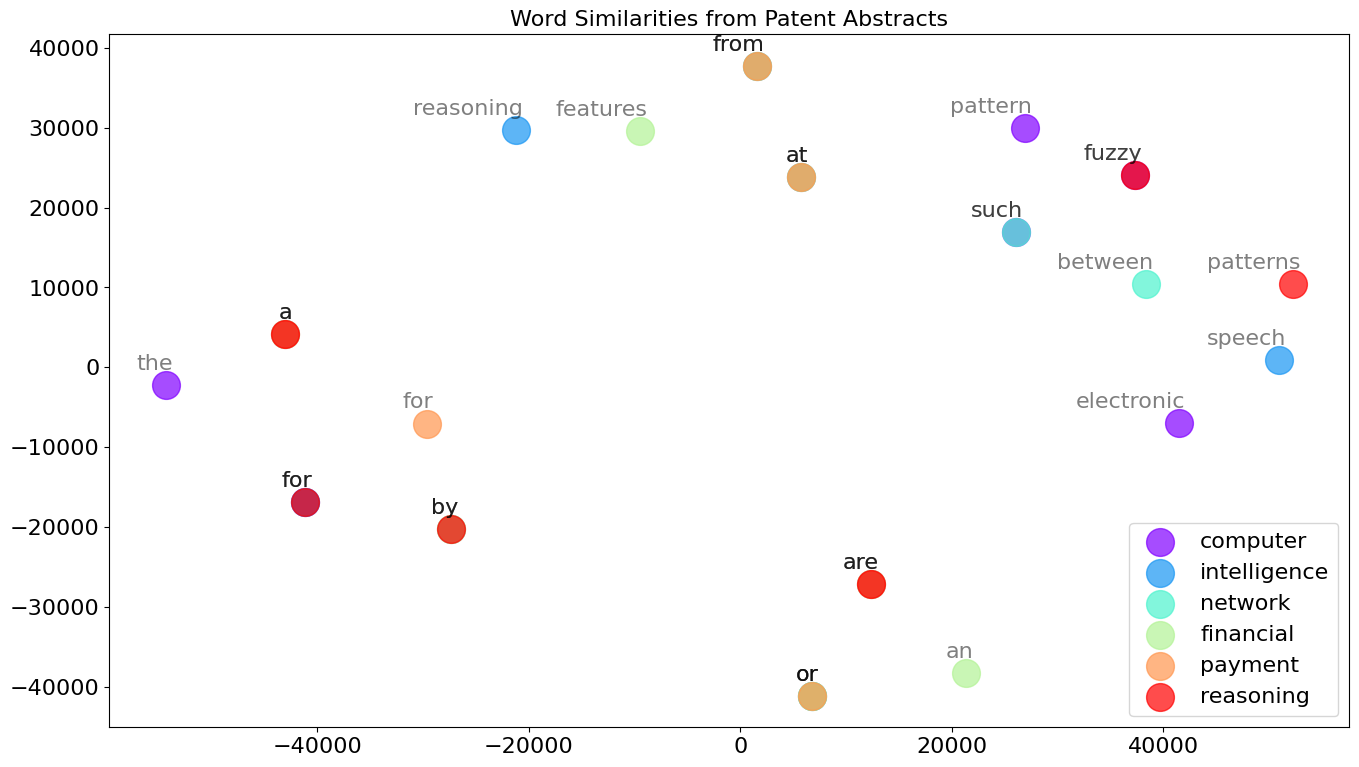

In [32]:
# 17. 2차원 시각화로 로컬 및 글로벌 구조 확인

# 주요 단어들 정의 (중심 단어)
keys = ['computer', 'intelligence', 'network', 'financial', 'payment', 'reasoning']

# 단어 및 임베딩 클러스터 초기화
embedding_clusters = []
word_clusters = []

# 각 중심 단어에 대해 가장 유사한 단어들을 클러스터링
for word in keys:
    embeddings = []
    words = []
    # 모델을 사용해 중심 단어와 유사한 단어 6개를 추출
    for similar_word, _ in model.wv.most_similar(word, topn=6):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

# t-SNE 파라미터 설정
perp = 9  # perplexity 값 설정 (데이터 밀집도에 영향을 미침)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

# t-SNE로 차원 축소 수행 (768차원 -> 2차원)
tsne_model_en_2d = TSNE(perplexity=perp, n_components=2, init='pca', n_iter=50000, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# 시각화 함수 정의
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))  # 클러스터별 색상 설정
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label, s=400)  # 클러스터 점 그리기
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 8),
                         textcoords='offset points', ha='right', va='bottom', size=16)  # 단어 주석 추가
    plt.legend(loc=4, prop={'size': 16})
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(False)  # 그리드 제거
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')  # 파일 저장
    plt.show()

# 결과를 파일로 저장 및 시각화
outfile = "/content/drive/My Drive/data/TSNE.png"
tsne_plot_similar_words('Word Similarities from Patent Abstracts', keys, embeddings_en_2d, word_clusters, 0.7, outfile)

# 플롯 설명:
# 각 중심 단어에 대해 유사한 단어들이 같은 클러스터 내에 위치하며, 관련 있는 클러스터들끼리 가까운 곳에 위치합니다.
# 예: computer와 telephone 클러스터, car와 boat 클러스터, drug와 chemical 클러스터가 각각 서로 가까운 위치에 있음.


In [33]:
# 18. 기존의 특허 카테고리 구조와 모델 출력을 비교하여 구조적 일관성 확인

# 특정 단어들 간의 코사인 유사도를 계산하고, 이를 0에서 100 사이의 값으로 변환
# 이 값은 거리로 해석되며, 값이 클수록 두 단어 간의 거리가 더 멀다고 판단
# ['computer', 'intelligence', 'network', 'financial', 'payment', 'reasoning']

# 유사도를 거리 값으로 변환하여 출력
print((- (model.wv.similarity('financial', 'computer') + 1) * 50) + 100)
print((- (model.wv.similarity('financial', 'intelligence') + 1) * 50) + 100)
print((- (model.wv.similarity('financial', 'network') + 1) * 50) + 100)
print((- (model.wv.similarity('financial', 'payment') + 1) * 50) + 100)
print((- (model.wv.similarity('financial', 'reasoning') + 1) * 50) + 100)
print((- (model.wv.similarity('financial', 'value') + 1) * 50) + 100)
print((- (model.wv.similarity('financial', 'fuzzy') + 1) * 50) + 100)
print((- (model.wv.similarity('financial', 'features') + 1) * 50) + 100)
print((- (model.wv.similarity('financial', 'logic') + 1) * 50) + 100)

# 거리 값 설명:
# 여기서 유사도 값 (-1 ~ 1 사이)을 0에서 100 사이로 변환합니다.
# 유사도가 높으면(가깝다면) 값이 작고, 유사도가 낮으면(멀다면) 값이 큽니다.


0.08567273616790771
0.04818439483642578
0.01709163188934326
0.019916892051696777
0.01679062843322754
0.018605589866638184
0.01608133316040039
0.014227628707885742
0.030860304832458496


In [34]:
# # 19. 모델이 물리적 세계의 객관적 규칙성을 포착하는지 확인
# # 원소 주기율표에서 물리적 거리를 모델이 어떻게 표현하는지 확인하기 위해 유사도를 거리로 변환

# # 'hydrogen'과 다른 알칼리 금속 원소 간의 유사도를 거리 값으로 변환하여 출력
# print((- (model.wv.similarity('hydrogen', 'lithium') + 1) * 50) + 100)
# print((- (model.wv.similarity('hydrogen', 'sodium') + 1) * 50) + 100)
# print((- (model.wv.similarity('hydrogen', 'potassium') + 1) * 50) + 100)
# print((- (model.wv.similarity('hydrogen', 'rubidium') + 1) * 50) + 100)
# print((- (model.wv.similarity('hydrogen', 'caesium') + 1) * 50) + 100)
# print((- (model.wv.similarity('hydrogen', 'francium') + 1) * 50) + 100)


In [35]:
# # 20. 특허 임베딩 모델이 사회적 관계와 관련된 지식을 잘 포착하는지 확인
# # 여기서는 성별을 기준으로 개념이 여성/남성 차원에 맞게 투영되는지 확인

# # 벡터 정규화 함수
# def normalize(vector):
#     normalized_vector = vector / np.linalg.norm(vector)  # 벡터의 크기를 1로 만듦 (정규화)
#     return normalized_vector

# # 특정 차원을 정의하는 함수 (성별 차원)
# def dimension(model, positives, negatives):
#     # 긍정적 단어와 부정적 단어의 벡터 차이를 계산하여 차원 생성
#     diff = sum([normalize(model.wv[x]) for x in positives]) - sum([normalize(model.wv[y]) for y in negatives])
#     return diff

# # 성별 차원 정의 ('man', 'male' vs. 'woman', 'female')
# Gender = dimension(model, ['man', 'him', 'he', 'male', 'men'], ['woman', 'her', 'she', 'female', 'women'])

# # 확인할 개념 리스트 정의
# Concepts = ['dietitian', 'hygienist', 'lipstick', 'breastpump', 'tampon',
#             'military', 'farming', 'police', 'hammer', 'fishing']

# # 개념을 성별 차원에 투영하여 데이터프레임 생성
# def makeDF(model, word_list):
#     g = []  # 성별 투영 값을 저장할 리스트
#     for word in word_list:
#         # 각 단어가 성별 차원에 얼마나 투영되는지 계산 (코사인 유사도)
#         g.append(sklearn.metrics.pairwise.cosine_similarity(model.wv[word].reshape(1, -1), Gender.reshape(1, -1))[0][0])
#     # 데이터프레임 생성 (단어별 성별 투영 값)
#     df = pd.DataFrame({'gender': g}, index=word_list)
#     return df

# # 개념 리스트를 성별 차원에 투영한 데이터프레임 생성 및 정렬
# df = makeDF(model, Concepts)
# df = df.sort_values(by=['gender'])  # 성별 투영 값을 기준으로 정렬

# # 결과 출력
# df


In [36]:
# # 21. 임베딩 모델이 아날로지 추론 작업을 해결할 수 있는지 검증
# # 모델이 잘 학습되었다면 아날로지 작업에서 의미 있는 결과를 도출할 수 있음

# # 모델의 코사인 유사도를 사용해 아날로지 추론 수행 (cosmul 방식 사용)
# # 각 출력은 아날로지에서 유사도가 가장 높은 단어를 반환함

# # Synonym 추론: 'tiny'는 'large'처럼 크기와 관련된 반대 단어를 나타내므로 'big'을 뺀 결과로 유사한 단어를 반환
# print(model.wv.most_similar_cosmul(positive=['tiny', 'large'], negative=['big'])[0])

# # Antonym 추론: 'downward'는 'liquid'와 관련 있고, 'solid'와 반대인 유사 단어를 반환
# print(model.wv.most_similar_cosmul(positive=['downward', 'liquid'], negative=['solid'])[0])

# # Type 추론: 'car'는 'animal'과 관련 있으며, 'cat'과 유사하지 않은 단어를 반환
# print(model.wv.most_similar_cosmul(positive=['car', 'animal'], negative=['cat'])[0])

# # Type 추론: 'skate'와 'airplane' 관련 단어 추론, 'fly'를 제거한 결과에서 두 번째 유사 단어를 반환
# print(model.wv.most_similar_cosmul(positive=['skate', 'airplane'], negative=['fly'])[1])

# # Item / Purpose 추론: 'hammer'와 'cut' 관련 단어 추론, 'knife' 제거 후 유사 단어 반환
# print(model.wv.most_similar_cosmul(positive=['hammer', 'cut'], negative=['knife'])[0])

# # Product / Worker 추론: 'farmer'와 'patient'의 관련성 추론, 'doctor'를 제거한 결과 유사 단어 반환
# print(model.wv.most_similar_cosmul(positive=['farmer', 'patient'], negative=['doctor'])[0])

# # Distance 추론: 'short'와 'longest'의 관련성 추론, 'long'을 제거한 유사 단어 반환
# print(model.wv.most_similar_cosmul(positive=['short', 'longest'], negative=['long'])[0])

# # Count 추론: 'spoon'과 'pens'의 관련성 추론, 'pen'을 제거한 유사 단어 반환
# print(model.wv.most_similar_cosmul(positive=['spoon', 'pens'], negative=['pen'])[0])


In [37]:
# 22. 특허 초록 데이터프레임 및 임베딩 모델 로드

# 'patents_processed_bigrams.csv' 파일에서 특허 데이터를 로드
df = pd.read_csv("/content/drive/My Drive/data/patents_processed_bigrams.csv")

# 실용적인 예시를 위해 상위 5개의 특허 초록만 사용
df = df.head()

# 'abstract_token_bigram' 열에 저장된 문자열을 실제 리스트로 변환
df["abstract_token_bigram"] = df["abstract_token_bigram"].progress_apply(lambda x: string_to_ls(x))

# 저장된 Word2Vec 임베딩 모델 로드
model = Word2Vec.load('/content/drive/My Drive/data/patentAbstractsW2V_300_10_5.model')

# 데이터프레임의 첫 5행 출력
df.head()


100%|██████████| 5/5 [00:00<00:00, 6331.98it/s]


,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract_token_bigram
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that..."
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that..."
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,"[higher, operational, speed, is, obtained, wit..."
3,46469565,1992,JP,Y10S 706/925,26.2,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin..."
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni..."


In [38]:
# 23. 각 특허 초록을 출력하여 내용을 확인

# 'abstract_token_bigram' 열의 데이터를 리스트로 변환
abstract_list = df['abstract_token_bigram'].tolist()

# 각 특허 초록을 출력
for abstract in abstract_list:
    print("")  # 각 초록 사이에 빈 줄 삽입
    print(len(abstract))  # 초록의 토큰 수 출력
    print(abstract)  # 초록 내용 출력



154
['a', 'neural_network', 'system', 'is', 'provided', 'that_models', 'the', 'system', 'in', 'a', 'system', 'model', 'with', 'the', 'output', 'thereof_providing', 'a', 'predicted_output', 'this', 'predicted_output', 'is', 'modified_or_controlled', 'by', 'an', 'output', 'control', 'input', 'data', 'is', 'processed', 'in', 'a', 'data_preprocess', 'step_to_reconcile', 'the', 'data', 'for', 'input', 'to', 'the', 'system', 'model', 'additionally_the_error', 'resulted_from_the_reconciliation', 'is', 'input', 'to', 'an', 'uncertainty_model', 'to', 'predict_the_uncertainty', 'in', 'the', 'predicted_output', 'this', 'is', 'input', 'to', 'a', 'decision_processor', 'which', 'is', 'utilized', 'to', 'control', 'the', 'output', 'control', 'the', 'output', 'control', 'is', 'controlled_to_either', 'vary_the_predicted', 'output', 'or', 'to', 'inhibit_the_predicted', 'output', 'whenever', 'the', 'output', 'of', 'the', 'uncertainty_model', 'exceeds_a_predetermined', 'decision_threshold', 'input', 'by',

In [39]:
# # 24. 개념적 범위 측정
# # 값이 클수록 범위가 넓어지므로, 유사도 값을 변환하여 범위를 반영

# # 두 개의 단어 집합 정의
# l1 = ["chemistry", "biochemistry", "analytical_chemistry"]
# l2 = ["chemistry", "oceanography", "computer"]

# # 첫 번째 단어 집합의 유사도 계산
# sims1 = [
#     model.wv.similarity(l1[0], l1[1]),  # 'chemistry'와 'biochemistry' 간 유사도
#     model.wv.similarity(l1[0], l1[2]),  # 'chemistry'와 'analytical_chemistry' 간 유사도
#     model.wv.similarity(l1[1], l1[2])   # 'biochemistry'와 'analytical_chemistry' 간 유사도
# ]

# # 첫 번째 집합의 유사도의 평균을 계산하고, 변환하여 범위를 반영 (값이 클수록 범위가 넓음)
# sims1mean = (((sum(sims1) / float(len(sims1)) + 1) * -50) + 100)  # 유사도 평균을 거리로 변환

# # 첫 번째 단어 집합과 범위 출력
# print(l1)
# print(sims1mean)
# print("")

# # 두 번째 단어 집합의 유사도 계산
# sims2 = [
#     model.wv.similarity(l2[0], l2[1]),  # 'chemistry'와 'oceanography' 간 유사도
#     model.wv.similarity(l2[0], l2[2]),  # 'chemistry'와 'computer' 간 유사도
#     model.wv.similarity(l2[1], l2[2])   # 'oceanography'와 'computer' 간 유사도
# ]

# # 두 번째 집합의 유사도의 평균을 계산하고, 변환하여 범위를 반영 (값이 클수록 범위가 넓음)
# sims2mean = (((sum(sims2) / float(len(sims2)) + 1) * -50) + 100)  # 유사도 평균을 거리로 변환

# # 두 번째 단어 집합과 범위 출력
# print(l2)
# print(sims2mean)


In [40]:
# 25. 주어진 문서에서 100개의 임의의 단어 쌍을 샘플링하고 평균 유사도를 계산하는 함수
# 많은 단어가 있는 문서에서 계산 부담을 줄이기 위해 유용

def conceptual_breadth(text):
    """
    주어진 텍스트에서 100개의 임의의 단어 쌍을 샘플링하여 평균 유사도를 계산하는 함수.
    계산이 어려운 경우, 대신 단어-단어 간 코사인 거리의 평균을 사용할 수 있음.
    """
    numUnique = len(text)  # 텍스트 내 고유 단어 수
    distances = []

    for i in range(100):
        try:
            # 임의의 두 단어를 샘플링
            rand1 = text[random.randrange(0, numUnique)]
            rand2 = text[random.randrange(0, numUnique)]

            # 두 단어 간 코사인 유사도를 거리로 변환
            dist = (((model.wv.similarity(rand1, rand2) + 1) * -50) + 100)  # 값이 클수록 더 넓은 개념적 범위를 의미
            distances.append(dist)
        except:
            continue  # 예외 발생 시 무시하고 계속 진행

    try:
        # 계산된 거리 값 리스트에서 평균 계산
        dists = distances
        dists.sort(reverse=True)  # 내림차순으로 정렬 (옵션)
        breadth = float(sum(dists)) / float(len(dists))  # 평균 거리 계산
    except:
        breadth = np.nan  # 예외 발생 시 NaN 값 할당

    return breadth  # 개념적 범위 반환

# 각 특허 초록에 대해 개념적 범위를 계산하고 새로운 열에 저장
df['abstract_breadth'] = df['abstract_token_bigram'].apply(conceptual_breadth)

# 데이터프레임의 첫 5행 출력
df.head()


,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract_token_bigram,abstract_breadth
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that...",3.185765
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that...",1.222642
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,"[higher, operational, speed, is, obtained, wit...",0.208806
3,46469565,1992,JP,Y10S 706/925,26.2,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin...",0.056181
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni...",0.041439


In [41]:
# 26. 특허 초록 데이터프레임 및 임베딩 모델 로드

# 'patents_processed_bigrams.csv' 파일에서 데이터 로드
df = pd.read_csv("/content/drive/My Drive/data/patents_processed_bigrams.csv")

# 'abstract_token_bigram' 열의 문자열을 리스트로 변환
df["abstract_token_bigram"] = df["abstract_token_bigram"].progress_apply(lambda x: string_to_ls(x))

# 저장된 Word2Vec 임베딩 모델 로드
model = Word2Vec.load('/content/drive/My Drive/data/patentAbstractsW2V_300_10_5.model')

# 모델의 어휘(vocab) 로드
model_vocab = model.wv.key_to_index

# 데이터프레임의 첫 5행 출력
df.head()


100%|██████████| 75/75 [00:00<00:00, 23125.25it/s]


,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract_token_bigram
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that..."
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that..."
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,"[higher, operational, speed, is, obtained, wit..."
3,46469565,1992,JP,Y10S 706/925,26.2,Economic phenomenon predicting and analyzing s...,"[an, economic_phenomenon, predicting, analyzin..."
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni..."


In [42]:
# 27. 특허 초록의 중심 벡터(centroid vector)를 계산하는 함수
def get_centroid_vector(token_ls):
    total_vector = []  # 전체 벡터를 저장할 리스트

    # 각 토큰에 대해 벡터를 추출하고, 모델 어휘에 있는 경우 벡터를 리스트에 추가
    for token in token_ls:
        if token in model_vocab:
            v = model.wv[token]
            total_vector.append(v)

    # 벡터가 하나 이상 있는 경우 평균을 계산하여 중심 벡터 생성
    if len(total_vector) > 0:
        centroid_vector = sum(total_vector) / len(total_vector)
    else:
        centroid_vector = np.nan  # 벡터가 없으면 NaN 반환

    return centroid_vector  # 중심 벡터 반환

# 더 빠르게 코사인 유사도를 계산하는 함수
def alt_cosine(x, y):
    return np.inner(x, y) / np.sqrt(np.dot(x, x) * np.dot(y, y))


In [43]:
# 28. 테이블 2의 각 특허 초록에 대해 중심 벡터(centroid vector) 계산
# 예시에서는 특정 특허 초록에 대해서만 중심 벡터를 계산함

# id가 48332311, 52886028, 53779347 특허 초록만 필터링
df = df.loc[df['appln_id'].isin([48332311, 52886028, 53779347])]

# 각 특허 초록에 대해 중심 벡터를 계산하여 새로운 'centroid_vector' 열에 저장
df['centroid_vector'] = df['abstract_token_bigram'].progress_apply(lambda x: get_centroid_vector(x))

# 데이터프레임의 첫 5행 출력
df.head()


100%|██████████| 5/5 [00:00<00:00, 2556.57it/s]


,appln_id,earliest_filing_year,person_ctry_code,cpc_class_symbol,nace2_code,appln_title,abstract_token_bigram,centroid_vector
0,48332311,1992,US,G06N 3/049,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that...","[0.012293875, 0.2197882, 0.08354031, 0.0467284..."
1,48332311,1992,US,G06N 3/047,26.2,Method for operating a neural network with mis...,"[a, neural_network, system, is, provided, that...","[0.012293875, 0.2197882, 0.08354031, 0.0467284..."
2,53779347,1990,US,G06N 3/048,26.2,Operational speed improvement for neural network,"[higher, operational, speed, is, obtained, wit...","[0.008824813, 0.16043253, 0.05706294, 0.036184..."
4,52886028,1990,JP,Y10S 706/902,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni...","[0.0103911655, 0.1883434, 0.068113, 0.04251354..."
17,52886028,1990,JP,Y10S 706/90,26.2,Fuzzy backward reasoning device,"[a, sequential, type, fuzzy, backward, reasoni...","[0.0103911655, 0.1883434, 0.068113, 0.04251354..."


In [44]:
# 29. 세 개의 특허 초록에 대한 유사도 비교 (테이블 2)

# 각 특허 초록의 중심 벡터 추출
v1 = df.loc[df['appln_id'] == 48332311, 'centroid_vector'].iloc[0]
v2 = df.loc[df['appln_id'] == 52886028 , 'centroid_vector'].iloc[0]
v3 = df.loc[df['appln_id'] == 53779347, 'centroid_vector'].iloc[0]

# 중심 벡터 간 코사인 유사도 비교
print(alt_cosine(v1, v2))  # 48332311 8406638 특허 초록 간의 유사도
print(alt_cosine(v1, v3))  # 48332311 52886028 특허 초록 간의 유사도
print(alt_cosine(v3, v2))  # 52886028 53779347 특허 초록 간의 유사도


0.9999576
0.9999238
0.99998355


In [45]:
# 30. 이전에 저장한 전처리된 데이터를 로드

# 'patents_processed_bigrams.csv' 파일에서 데이터 로드
df = pd.read_csv("/content/drive/My Drive/data/patents_processed_bigrams.csv")

# 필요한 열만 선택 ('abstract_token_bigram', 'id')
df = df[["abstract_token_bigram", "appln_id"]]

# 'abstract_token_bigram' 열의 문자열을 리스트로 변환
df["abstract_token_bigram"] = df["abstract_token_bigram"].progress_apply(lambda x: string_to_ls(x))


100%|██████████| 75/75 [00:00<00:00, 22007.33it/s]


In [ ]:
# 31. Doc2Vec 임베딩 모델 학습

# 모델 파라미터 설정
VectorSize = 300  # 각 단어를 임베딩할 차원의 수
Window = 5  # 초점 단어 앞뒤로 고려할 단어 수
Epochs = 10  # 코퍼스를 학습할 반복 횟수
MinCount = 1  # 최소 등장 횟수가 1 이상인 단어만 포함
Workers = 6  # 6개의 프로세서 사용 (8개의 CPU 중 6개 할당)

# 모델 학습 시작 시간 기록
start = time.time()

# 학습에 사용할 문서 리스트 생성
trained_bigram = list(df.itertuples(index=False, name=None))  # DataFrame에서 튜플 형태로 데이터 추출
docs = []

# 각 문서를 TaggedDocument 형식으로 변환
for doc in trained_bigram:
    T = TaggedDocument(doc[0], [doc[1]])  # 문서의 텍스트와 그 ID를 태그로 연결
    docs.append(T)

# Doc2Vec 모델 학습
modeldv = Doc2Vec(docs, vector_size=VectorSize, window=Window, epochs=Epochs, workers=Workers)

# 학습에 걸린 시간 출력 (분 단위)
print("Minutes it took to train the model: ", ((time.time() - start) / 60))

# 학습된 모델 저장
modeldv.save('/content/drive/My Drive/data/patentAbstractsD2V_300_10_5.model')


In [ ]:
# 32. Doc2Vec 모델을 로드하여 나중에 사용할 수 있도록 준비

# 저장된 Doc2Vec 모델 로드
modeldv = Doc2Vec.load('/content/drive/My Drive/data/patentAbstractsD2V_300_10_5.model')


In [ ]:
# 33. 테이블 2의 세 개의 특허 초록 간 유사도 비교

# Doc2Vec 모델을 사용하여 세 개의 특허 초록 간 유사도 계산 및 출력
print(modeldv.dv.similarity(48332311, 52886028))   # 특허 48332311 52886028 간의 유사도
print(modeldv.dv.similarity(48332311, 53779347))  # 특허 48332311 10000142 간의 유사도
print(modeldv.dv.similarity(53779347, 52886028))   # 특허 10000142와 8406638 간의 유사도


In [ ]:
# 34. 특허 초록 데이터프레임 및 임베딩 모델 로드

# 'patents_processed_bigrams.csv' 파일에서 데이터 로드
df = pd.read_csv("/content/drive/My Drive/data/patents_processed_bigrams.csv")

# 예시로 사용할 특정 특허 초록만 필터링
df = df.loc[df['id'].isin([48332311, 52886028, 53779347])]

# 'abstract_token_bigram' 열의 문자열을 리스트로 변환
df["abstract_token_bigram"] = df["abstract_token_bigram"].apply(lambda x: string_to_ls(x))

# 저장된 Word2Vec 모델 로드
model = Word2Vec.load('/content/drive/My Drive/data/patentAbstractsW2V_300_10_5.model')

# 모델의 어휘 로드
model_vocab = model.wv.key_to_index

# 데이터프레임의 첫 5행 출력
df.head()


In [ ]:
# 35. 'time' 및 'geometry' 아키타입에 대해 중심 벡터 계산

# 'time' 아키타입을 구성하는 단어 리스트 정의
time = ['interval', 'time', 'period', 'preceding', 'time_interval', 'start', 'timing', 'immediately_preceding',
        'nanosecond', 'seconds', 'minutes', 'hours', 'synchronize', 'synchronized', 'instant', 'continuation', 'duration']

# 'geometry' 아키타입을 구성하는 단어 리스트 정의
geometry = ['plane', 'ellipse', 'parabola', 'straight_line', 'bisector', 'arc_circle', 'tangent', 'hyperbolic',
            'tangents', 'curvature', 'angle', 'circular_arc', 'sagittal', 'axis_symmetry', 'meridian',
            'ellipsoid', 'paraboloid', 'regular_polygon', 'dihedral', 'intersection', 'geometry', 'geometric']

# 'time' 아키타입의 중심 벡터 계산
time_vector = get_centroid_vector(time)

# 'geometry' 아키타입의 중심 벡터 계산
geometry_vector = get_centroid_vector(geometry)

# 결과 확인을 위한 출력
print("Time Centroid Vector:", time_vector)
print("Geometry Centroid Vector:", geometry_vector)


In [ ]:
# 36. 특허 초록의 중심 벡터와 'time' 및 'geometry' 아키타입 벡터 간의 유사도 측정

# 테이블 2의 세 개의 특허 초록 중심 벡터 추출
v1 = df.loc[df['appln_id'] == 48332311, 'centroid_vector'].iloc[0]
v2 = df.loc[df['appln_id'] == 53779347 , 'centroid_vector'].iloc[0]
v3 = df.loc[df['appln_id'] == 52886028, 'centroid_vector'].iloc[0]

# 'time' 아키타입 벡터와 특허 초록 간의 유사도 비교
print("Similarity between the time archetype and patent 10000000 (coherent light receiver): ", alt_cosine(v1, time_vector))
print("Similarity between the time archetype and patent 8406638 (coherent light receiver): ", alt_cosine(v2, time_vector))
print("Similarity between the time archetype and patent 10000142 (head and neck restraint): ", alt_cosine(v3, time_vector))
print("")

# 'geometry' 아키타입 벡터와 특허 초록 간의 유사도 비교
print("Similarity between the geometry archetype and patent 10000000 (coherent light receiver): ", alt_cosine(v1, geometry_vector))
print("Similarity between the geometry archetype and patent 8406638 (coherent light receiver): ", alt_cosine(v2, geometry_vector))
print("Similarity between the geometry archetype and patent 10000142 (head and neck restraint): ", alt_cosine(v3, geometry_vector))


In [ ]:
# 37. 특정 뇌 영역과 가장 관련된 용어 추출
# 'hippocampus', 'subthalamic_nucleus', 'nucleus_basalis'에 가장 유사한 상위 10개의 단어를 출력

# 'hippocampus'와 가장 유사한 상위 10개 용어 출력
print("hippocampus: ", model.wv.most_similar('hippocampus', topn=10))
print("")

# 'subthalamic_nucleus'와 가장 유사한 상위 10개 용어 출력
print("subthalamic_nucleus: ", model.wv.most_similar('subthalamic_nucleus', topn=10))
print("")

# 'nucleus_basalis'와 가장 유사한 상위 10개 용어 출력
print("nucleus_basalis: ", model.wv.most_similar('nucleus_basalis', topn=10))
